In [1]:
import importlib.util

if importlib.util.find_spec('pvlib') is None:
    !pip install pvlib
        
if importlib.util.find_spec('meteostat') is None:
    !pip install meteostat

if importlib.util.find_spec('timezonefinder') is None:
    !pip install timezonefinder


# Tutorial 3 - Datos solares y climatológicos

Este es un tutorial para utilizar las librerías:
- `pvlib` para determinar ángulos solares y niveles de irradiación solar.
- `meteostat` para determinar condiciones climáticas.

> Para mayor información de las funciones de este tutorial, revisar la documentación oficial de [`pvlib`](https://pvlib-python.readthedocs.io/en/stable/reference/index.html) y [`meteostat`](https://dev.meteostat.net/python/)

## Definir localización y tiempo de estudio

Antes de cualquier estudio debemos definir la localización y tiempo de estudio.

### Latitud, longitud y altitud del sitio
Como sugerencia, recomendamos usar [google earth](https://www.google.es/intl/es/earth/index.html). para determinar las coordenadas y altitud del sitio. Esta información  se encuentra en la esquina inferior derecha. Otra alternativa es revisar las coordenadas en la dirección web del sitio.

Por ejemplo, consideramos las coordenadas del [Edificio A del campus de Peñalolén de la Universidad Adolfo Ibañez](https://earth.google.com/web/search/Universidad+Adolfo+Ib%c3%a1%c3%b1ez+-+Avenida+Diagonal+Las+Torres,+Santiago,+Pe%c3%b1alol%c3%a9n/@-33.48459063,-70.51846296,890.86619233a,397.56893117d,35y,0h,0t,0r/data=CmMaORIzCiUweDk2NjJkMjE5NzFkMWM0NTc6MHhhMmQwYWVmZDlhMDcwZDA2KgpFZGlmaWNpbyBBGAIgASImCiQJJzw65qu9QMARKyzNGmi-QMAZprJq4cKgUcAhENuZjZuhUcA6AwoBMA).

Según esta información, el edificio se encuentre en las coordeandas 33.485° S, 70.518°O, y a una altura de 890.867 m

In [2]:
# Definimos latitud y longitud del lugar
lat, lon = -33.485, -70.518

# Altitud (en metros)
alt = 890.86619233

### Zonas horaria

Para identificar la zona horaria podemos usar la función `pytz.country_timezones`. 

> **Nota** La librería `pytz` viene incluída dentro del paquete de instalación de `pvlib` y, por lo tanto, no requiere instalación.

In [3]:
import pytz

pytz.country_timezones('CL')

['America/Santiago', 'America/Punta_Arenas', 'Pacific/Easter']

En Chile, la zona horaria es `America/Santiago` en casi todo el territorio, excepto en Punta Arenas e Isla de Pascua.

In [4]:
tz_uai = 'America/Santiago'

> La lista completa de zonas horarias se encuentra disponible en [Wikipedia](https://en.wikipedia.org/wiki/List_of_tz_database_time_zones)

Otra alternativa es usar la librería `timezonefinder` para identificar zonas horarias basadas en coordenadas de latitud y longitud. 

In [5]:
from timezonefinder import TimezoneFinder

tz_uai = TimezoneFinder().timezone_at(lat=lat, lng=lon)

print('La zona horaria en la UAI es:', tz_uai)

La zona horaria en la UAI es: America/Santiago


### Tiempo de estudio
Una vez definida la ubicación, debemos definir el intervalo de tiempo para nuestro estudio. Las librerías `pvlib` y `meteostat` utilizan distintos formatos para definir el intervalo de tiempo. Sin embargo, algo común en ambas es la definición de la fecha de comienzo y termino en formato `datetime`.

En este tutorial, consideraremos el periodo comprendido entre el 21 y 22 de diciembre del 2022

In [6]:
from datetime import datetime

start_date = datetime(year = 2022, month = 12, day = 21, hour = 0, minute = 0)
end_date   = datetime(year = 2022, month = 12, day = 22, hour = 0, minute = 0)

print(start_date)
print(end_date)

2022-12-21 00:00:00
2022-12-22 00:00:00


**La frecuencia entre este intervalo será en horas.** Sin embargo, la definición de esto es particular para cada librería.

## Estimación de ángulos solares e irradiación (`pvlib`)

### Inicializar localización y tiempo de estudio en `pvlib`

Para inicializar la localización usamos la función `pvlib.location.Location()`. Esta función crea un objeto `Location` que utilizaremos después para determinar los ángulos solares e irradiación solar.

In [7]:
from pvlib.location import Location

loc_pvlib = Location(latitude  = lat, 
                     longitude = lon, 
                     tz        = tz_uai,
                     altitude  = alt)

Luego, debemos definir el intervalo de tiempo. Usamos la función `data_range` de pandas para generar un arreglo con las fechas para la zona horaria correspondiente.

In [8]:
import pandas as pd

time_study = pd.date_range(start = start_date, 
                           end   = end_date, 
                           freq  = 'H', 
                           tz    = tz_uai)

Para verificar, usamos `print` para imprimir cada elemento del arreglo `times`.

In [9]:
for i in range(len(time_study)):
    print(time_study[i])

2022-12-21 00:00:00-03:00
2022-12-21 01:00:00-03:00
2022-12-21 02:00:00-03:00
2022-12-21 03:00:00-03:00
2022-12-21 04:00:00-03:00
2022-12-21 05:00:00-03:00
2022-12-21 06:00:00-03:00
2022-12-21 07:00:00-03:00
2022-12-21 08:00:00-03:00
2022-12-21 09:00:00-03:00
2022-12-21 10:00:00-03:00
2022-12-21 11:00:00-03:00
2022-12-21 12:00:00-03:00
2022-12-21 13:00:00-03:00
2022-12-21 14:00:00-03:00
2022-12-21 15:00:00-03:00
2022-12-21 16:00:00-03:00
2022-12-21 17:00:00-03:00
2022-12-21 18:00:00-03:00
2022-12-21 19:00:00-03:00
2022-12-21 20:00:00-03:00
2022-12-21 21:00:00-03:00
2022-12-21 22:00:00-03:00
2022-12-21 23:00:00-03:00
2022-12-22 00:00:00-03:00


### Estimar ángulos solares (`get_solarposition`)

Para acceder a los ángulos solares usamos la función `get_solarposition` del objeto `loc_pvlib`. Esta función crea un *dataframe* con los ángulos solares

In [10]:
sol_pos = loc_pvlib.get_solarposition(times = time_study)
sol_pos.head()


,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2022-12-21 00:00:00-03:00,118.310953,118.310953,-28.310953,-28.310953,206.108725,2.160758
2022-12-21 01:00:00-03:00,122.292222,122.292222,-32.292222,-32.292222,190.845847,2.140015
2022-12-21 02:00:00-03:00,122.881072,122.881072,-32.881072,-32.881072,174.524133,2.119271
2022-12-21 03:00:00-03:00,119.976535,119.976535,-29.976535,-29.976535,158.754981,2.098524
2022-12-21 04:00:00-03:00,114.043325,114.043325,-24.043325,-24.043325,144.812625,2.077775


En este curso, solo usaremos:
- `'apperent_zenith'`: ángulo cenital solar aparente (con corrección por el índice de refracción)
- `'apperent_elevation'`: ángulo de elevación solar aparente (con corrección por el índice de refracción)
- `'azimuth'`: ángulo acimutal solar

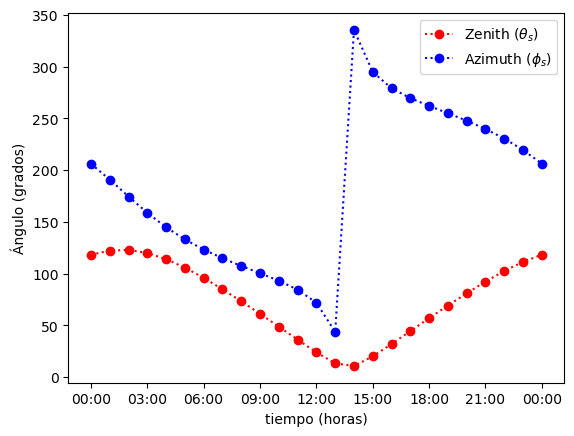

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(time_study, sol_pos['apparent_zenith'],'o:r', label=r'Zenith ($\theta_s$)')
ax.plot(time_study, sol_pos['azimuth'],'o:b', label=r'Azimuth ($\phi_s$)')

ax.set_xlabel('tiempo (horas)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = tz_uai))
ax.set_ylabel('Ángulo (grados)')
plt.legend()
plt.show()

### Estimar irradiación solar (`get_clearsky`)

Para acceder a la irradiación solar usamos la función `get_clearsky` del objeto `loc_pvlib`. Esta función crea un *dataframe* con los niveles de irradiación horizontal global (`ghi`), normal directa (`dni`) y horizontal difusa (`dhi`), calculados en base al modelo de [Ineichen y Perez (2022)](https://www.sciencedirect.com/science/article/abs/pii/S0038092X02000452).`

In [12]:
sol_irr = loc_pvlib.get_clearsky(times = time_study)
sol_irr.head()

,ghi,dni,dhi
2022-12-21 00:00:00-03:00,0.0,0.0,0.0
2022-12-21 01:00:00-03:00,0.0,0.0,0.0
2022-12-21 02:00:00-03:00,0.0,0.0,0.0
2022-12-21 03:00:00-03:00,0.0,0.0,0.0
2022-12-21 04:00:00-03:00,0.0,0.0,0.0


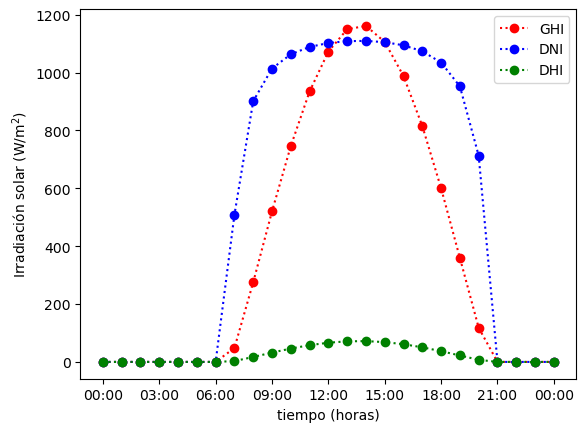

In [13]:
fig, ax = plt.subplots()
ax.plot(time_study, sol_irr['ghi'],'o:r', label=r'GHI')
ax.plot(time_study, sol_irr['dni'],'o:b', label=r'DNI')
ax.plot(time_study, sol_irr['dhi'],'o:g', label=r'DHI')

ax.set_xlabel('tiempo (horas)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = tz_uai))
ax.set_ylabel('Irradiación solar ($\mathrm{W/m^2}$)')
plt.legend()
plt.show()

## Estimación de condiciones ambientales (`meteostat`)

### Inicializar localización y tiempo de estudio en `meteostat`

Lo primero que debemos hacer es inicializar la localización usando la función `meteostat.Point()`. Esta función crea un objeto que generará la información meteorologica a través de la interpolación de datos de estaciones meterológicas cercanas. 

In [14]:
import meteostat

loc_meteo = meteostat.Point(lat=lat, 
                            lon=lon, 
                            alt= alt)

Luego, para extraer los datos horarios, utilizamos la función `meteostat.Hourly` indicando la ubicación del objeto `Point`, el inicio (`start`), el término (`end`) y la zona horaria (`timezone`) del periodo donde queremos extraer los datos.

> La función entregará un objeto, el cual podemos convertir a un *dataframe* usando `.fetch()`

In [15]:
from meteostat import Hourly

# Creamos un objeto con las condiciones climáticas
meteo_data = Hourly(loc      = loc_meteo,   # localización
                    start    = start_date,  # inicio
                    end      = end_date,    # término
                    timezone = tz_uai)      # zona horaria

# convertimos a dataframe
meteo_data = meteo_data.fetch() 

De este *dataframe* identificamos:
- `temp`: Temperatura ambiente (°C)
- `dwpt`: Temperatura de punto de rocío (°C)
- `rhum`: Humedad relativa (%)
- `prcp`: Precipitación total en una hora (mm)
- `snow`: Nieve acumulada (mm)
- `wdir`: Dirección del viento (°)
- `wspd`: Velocidad promedio del viento (km/h)
- `pres`: Presión atmosférica (hPa)

In [16]:
meteo_data['temp']

time
2022-12-21 00:00:00-03:00    16.1
2022-12-21 01:00:00-03:00    16.1
2022-12-21 02:00:00-03:00    15.4
2022-12-21 03:00:00-03:00    14.4
2022-12-21 04:00:00-03:00    15.0
2022-12-21 05:00:00-03:00    14.7
2022-12-21 06:00:00-03:00    14.5
2022-12-21 07:00:00-03:00    13.9
2022-12-21 08:00:00-03:00    13.5
2022-12-21 09:00:00-03:00    18.5
2022-12-21 10:00:00-03:00    20.5
2022-12-21 11:00:00-03:00    22.5
2022-12-21 12:00:00-03:00    25.5
2022-12-21 13:00:00-03:00    26.5
2022-12-21 14:00:00-03:00    29.5
2022-12-21 15:00:00-03:00    29.5
2022-12-21 16:00:00-03:00    30.5
2022-12-21 17:00:00-03:00    29.5
2022-12-21 18:00:00-03:00    28.5
2022-12-21 19:00:00-03:00    26.5
2022-12-21 20:00:00-03:00    24.5
2022-12-21 21:00:00-03:00    21.5
2022-12-21 22:00:00-03:00    17.1
2022-12-21 23:00:00-03:00    16.4
2022-12-22 00:00:00-03:00    15.4
Freq: H, Name: temp, dtype: float64

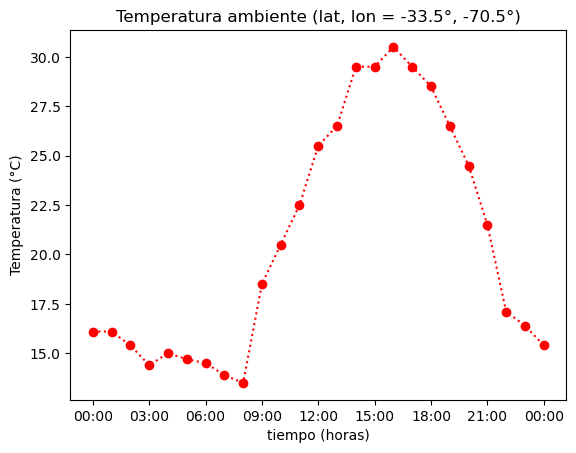

In [17]:
fig, ax = plt.subplots()
ax.plot(time_study, meteo_data['temp'],'o:r')

ax.set_xlabel('tiempo (horas)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = tz_uai))
ax.set_ylabel('Temperatura (°C)')
ax.set_title('Temperatura ambiente (lat, lon = %.1f°, %.1f°)' % (lat, lon))
plt.show()